Image Dimensions : (150, 200)


Text(0.5, 1.0, 'Image after appluing gaussian filter')

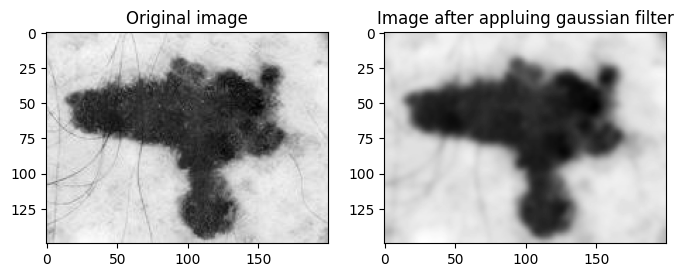

In [40]:
import cv2
from scipy import signal
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('melanoma.jpg', 0)
print('Image Dimensions :', img.shape)

g_img = gaussian_filter(img, sigma=2)

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap='gray')
plt.title("Original image")

fig.add_subplot(1,2,2)
#g_img = cv2.cvtColor(g_img, cv2.COLOR_BGR2RGB)
plt.imshow(g_img, cmap='gray')
plt.title("Image after appluing gaussian filter")



In [ ]:
print(img.shape)

(150, 200)


In [44]:
def initializePoints(img,w,num_points):
  n = img.shape[0]
  m = img.shape[1]
  theta = np.linspace(0, 2*np.pi, num_points, endpoint=False)
  init_points = []
  for t in theta:
    x = n//2 + (n//2-w-3)*np.cos(t)
    y = m//2 + (m//2-w-3)*np.sin(t)
    init_points.append((x,y))
  return init_points

def computeGradient(img):
  n = img.shape[0]
  x_filter = np.zeros((3,3))
  x_filter[1][0]= -1
  x_filter[1][-1] = 1
  y_filter = np.zeros((3,3))
  y_filter[0][1]= -1
  y_filter[-1][1] = 1
  Gx = np.square(signal.convolve2d(img, x_filter, mode='same'))
  Gy = np.square(signal.convolve2d(img, y_filter, mode='same'))
  G = Gx  +  Gy
  return G

def bestNeighbour(points, point, current, dI, w, v, alpha):
  ww = w//2
  loc = [(i, j) for i in range(-ww, ww+1, 1) for j in range(-ww, ww+1, 1)]
  e = [getE(point, neighbour, current, points[point - 1]+ loc[neighbour], dI, v, alpha)for neighbour in range(w**2)]
  v_min, i_min = min((value, i) for i, value in enumerate(e))
  return v_min, i_min

def getE(point, last_neighbour, curr, prev, dI,v,alpha):
  e = v[last_neighbour, point - 1, 0]
  e += alpha * ((curr[0]- prev[0]) ** 2 + (curr[1]- prev[1]) ** 2 - dI ** 2)
  return e

def minE(G, points, point, loc_neighbour, w, v, gamma, alpha):
  ii = np.roll(points, 1, axis=0)
  print(ii)
  dI = np.linalg.norm(points - ii, axis=0).mean()
  current_point = tuple(map(lambda x, y: int(x + y), points[point], loc_neighbour))
  e_min_internal, i_min = bestNeighbour(points, point, current_point, dI, w, v, alpha)
  e_external = -G[current_point]
  v_min = e_min_internal + gamma * e_external
  return v_min, i_min

def snake(img, num_points, num_iter, w, sigma, gamma, alpha):
  ww = w//2
  loc = [(i, j) for i in range(-ww, ww+1, 1) for j in range(-ww, ww+1, 1)]
  v = np.zeros((w**2, num_points, 2))
  points = initializePoints(img,w,num_points)

  fimg = gaussian_filter(img, sigma)
  G  = computeGradient(fimg)

  for iter in range(num_iter):
    for p in range(num_points):
      for n in range(w**2):
        v_min, i_min = minE(G, points, p, loc[n], w, v, gamma, alpha)
        v[n][p] = [v_min, i_min]
    i_min = v[:, num_points - 1, 0].argmin()
    i_min = int(i_min)
    points[0] = points[num_points - 1] + loc[i_min]
    for current in np.arange(num_points - 1, 0, -1):
      i_min = v[int(i_min), current, 1]
      points[current] = points[current - 1] + loc[int(i_min)]
    saveI(img, points, save_path=f"/content/imgs/iter {iter}.jpg")
    print(str(iter)+"th iteration completed")


def saveI(img, points, save_path):
  points = np.array(points, np.int32)
  points = np.roll(points, 1, axis=1)
  points = points.reshape((-1, 1, 2))
  img_copy = img.copy()
  cv2.polylines(img_copy, [points], True, (200, 200, 200), thickness=3)
  cv2.imwrite(save_path, img_copy)


def saveV(num_iter):
  imgs = []
  for i in range(num_iter):
    imgs.append(cv2.imread("/content/imgs/iter " + str(i) + ".jpg"))
  n, m, _ = imgs[1].shape
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter('melanoma_ac.mp4', fourcc, 5, (m, n))
  for j in range(num_iter):
    video.write(imgs[j])
  video.release()

In [ ]:
num_iter = 50
num_points = 1000
w = 5
sigma = 2
gamma = 1
alpha = 0.000005
snake(img, num_points, num_iter, w, sigma, gamma, alpha)

In [ ]:
saveV(num_iter)